In [1]:
import pandas as pd

In [2]:
#Import data

df_RS_sum = pd.read_csv('Summary_RS.csv', encoding='latin-1')
df_RS_pen = pd.read_csv('Penalties_RS.csv', encoding='latin-1')
df_RS_tgg = pd.read_csv('Team Goal-Games_RS.csv', encoding='latin-1')
df_RS_satc = pd.read_csv('SAT Counts_RS.csv', encoding='latin-1')
df_RS_satp = pd.read_csv('SAT Percentages_RS.csv', encoding='latin-1')

df_PS_sum = pd.read_csv('Summary_PS.csv', encoding='latin-1')
df_PS_pen = pd.read_csv('Penalties_PS.csv', encoding='latin-1')
df_PS_tgg = pd.read_csv('Team Goal-Games_PS.csv', encoding='latin-1')
df_PS_satc = pd.read_csv('SAT Counts_PS.csv', encoding='latin-1')
df_PS_satp = pd.read_csv('SAT Percentages_PS.csv', encoding='latin-1')

In [3]:
df_RS_sum.head()

,Team,Season,GP,W,L,T,OT,P,P%,RW,...,GA,GF/GP,GA/GP,PP%,PK%,Net PP%,Net PK%,Shots/GP,SA/GP,FOW%
0,Vegas Golden Knights,20202021,56,40,14,--,2,82,0.732,30,...,122,3.39,2.18,17.8,86.8,16.7,89.6,32.7,27.3,49.5
1,Colorado Avalanche,20202021,56,39,13,--,4,82,0.732,35,...,132,3.52,2.36,22.7,83.1,21.3,83.6,34.6,25.4,51.6
2,Carolina Hurricanes,20202021,56,36,12,--,8,80,0.714,27,...,134,3.13,2.39,25.6,85.2,22.0,89.2,32.0,28.2,53.9
3,Florida Panthers,20202021,56,37,14,--,5,79,0.705,26,...,151,3.36,2.70,20.5,79.8,18.4,82.1,34.9,30.0,50.2
4,Pittsburgh Penguins,20202021,56,37,16,--,3,77,0.688,29,...,155,3.45,2.77,23.7,77.4,21.1,81.3,30.1,30.0,49.3


In [4]:
#Create regular season dataframe

#Rename column with shared name but different data
df_RS_satp = df_RS_satp.rename({'GF':'5v5 GF', 'GA':'5v5 GA'}, axis=1)

#Drop duplicate columns
df_RS_pen = df_RS_pen.drop(['GP','W','L','T','OT','P'], axis=1)
df_RS_satc = df_RS_satc.drop(['GP'], axis=1)
df_RS_satp = df_RS_satp.drop(['GP','P','P%'], axis=1)
df_RS_tgg = df_RS_tgg.drop(['GP','W','L','T','OT','P','P%'], axis=1)

#Merge dataframes to create one regular season dataframe
df = pd.merge(df_RS_sum, df_RS_pen, how='inner', on=['Team','Season'])
df = pd.merge(df, df_RS_satc, how='inner', on=['Team','Season'])
df = pd.merge(df, df_RS_satp, how='inner', on=['Team','Season'])
df = pd.merge(df, df_RS_tgg, how='inner', on=['Team','Season'])

#Drop irrelevant columns (Ties not applicable in seasons being studied)
df = df.drop(['T'], axis=1)

#Convert season column to string
df['Season'] = df['Season'].apply(str)

In [5]:
df.describe()

,GP,W,L,OT,P,P%,RW,ROW,S/O Win,GF,...,Win% 1 Goal Game,Win% 2 Goal Game,Win% 3 Goal Game,Wins 1 Goal Game,Wins 2 Goal Game,Wins 3 Goal Game,Loss 1 Goal Game,Loss 2 Goal Game,Loss 3 Goal Game,OT Loss 1 Goal Game
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,...,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,74.311688,37.155844,28.707792,8.448052,82.759740,0.556929,28.707792,34.298701,2.857143,215.642857,...,0.501136,0.500071,0.499370,16.012987,7.733766,13.409091,7.564935,7.733766,13.409091,8.448052
std,10.380676,8.935594,7.828994,2.906028,17.944379,0.094176,8.100613,8.792547,1.693620,38.727923,...,0.100709,0.142229,0.163777,4.216350,2.985898,5.188743,2.976872,3.031517,5.099806,2.906028
min,56.000000,15.000000,12.000000,2.000000,37.000000,0.275000,11.000000,11.000000,0.000000,124.000000,...,0.227000,0.000000,0.032000,5.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000
25%,69.000000,31.000000,24.000000,7.000000,72.000000,0.488000,23.000000,28.000000,2.000000,189.250000,...,0.444000,0.403000,0.385500,13.000000,6.000000,10.000000,5.000000,5.250000,10.000000,7.000000
50%,82.000000,37.000000,28.000000,8.000000,81.500000,0.569000,29.000000,34.000000,3.000000,221.000000,...,0.500000,0.500000,0.515500,16.000000,7.000000,14.000000,8.000000,8.000000,13.000000,8.000000
75%,82.000000,44.000000,34.000000,10.000000,97.750000,0.622750,35.000000,41.000000,4.000000,243.000000,...,0.563000,0.611250,0.618000,19.000000,10.000000,17.000000,9.000000,10.000000,16.000000,10.000000
max,82.000000,62.000000,56.000000,15.000000,128.000000,0.780000,49.000000,56.000000,9.000000,319.000000,...,0.774000,0.786000,0.875000,25.000000,16.000000,30.000000,15.000000,16.000000,30.000000,15.000000


In [6]:
#Create postseason dataframe following same process as regular season

df_PS_satp = df_PS_satp.rename({'GF':'5v5 GF', 'GA':'5v5 GA'}, axis=1)

df_PS_pen = df_PS_pen.drop(['GP','W','L','T','OT','P'], axis=1)
df_PS_satc = df_PS_satc.drop(['GP'], axis=1)
df_PS_satp = df_PS_satp.drop(['GP','P','P%'], axis=1)
df_PS_tgg = df_PS_tgg.drop(['GP','W','L','T','P','P%'], axis=1)

df2 = pd.merge(df_PS_sum, df_PS_pen, how='inner', on=['Team','Season'])
df2 = pd.merge(df2, df_PS_satc, how='inner', on=['Team','Season'])
df2 = pd.merge(df2, df_PS_satp, how='inner', on=['Team','Season'])
df2 = pd.merge(df2, df_PS_tgg, how='inner', on=['Team','Season'])

df2 = df2.drop(['T'], axis=1)

df2['Season'] = df2['Season'].apply(str)

In [7]:
df2.describe()

,GP,W,L,P,P%,RW,ROW,S/O Win,GF,GA,...,5v5 S%,5v5 Sv%,5v5 S%+Sv%,Wins 2 Goal Game,Wins 3 Goal Game,Loss 1 Goal Game,Loss 2 Goal Game,Loss 3 Goal Game,OT Loss 1 Goal Game,Unnamed: 18
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,40.000000
mean,10.727273,5.363636,5.329545,5.117261,2.505977,4.738636,2.409091,16.272727,29.534091,14.671023,...,6.678409,92.272727,98.932955,1.829545,1.397727,2.136364,1.795455,1.397727,0.806818,0.075000
std,6.629310,4.849889,1.981069,8.387413,3.631763,4.450221,4.173359,21.981041,18.536047,17.144004,...,2.099669,1.863918,3.018781,2.354851,1.847893,1.709889,1.576837,1.255240,1.239744,0.266747
min,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.750000,...,0.900000,84.800000,90.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.750000,2.000000,4.000000,0.333000,0.333000,1.000000,0.000000,0.000000,16.000000,2.652500,...,5.750000,91.575000,97.150000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,8.500000,4.000000,4.000000,0.607500,0.612500,3.000000,0.000000,7.000000,23.000000,3.355000,...,6.900000,92.700000,99.850000,1.000000,1.000000,2.000000,1.500000,1.000000,0.000000,0.000000
75%,15.000000,8.250000,6.250000,6.500000,3.250000,7.000000,3.250000,26.250000,42.000000,22.250000,...,8.250000,93.300000,101.000000,2.000000,2.000000,3.000000,3.000000,2.000000,1.250000,0.000000
max,27.000000,18.000000,12.000000,36.000000,14.000000,16.000000,17.000000,86.000000,77.000000,82.000000,...,11.200000,95.200000,103.800000,12.000000,9.000000,6.000000,7.000000,5.000000,5.000000,1.000000


In [19]:
#Reduce regular season dataframe for initial heatmap
df_reg = df[['W','L','OT','P%', 'RW','ROW','S/O Win','GF/GP','GA/GP','PP%','PK%','Pen Drawn/60','Pen Taken/60','SAT%','USAT %','Win% 1 Goal Game','Win% 2 Goal Game', 'Win% 3 Goal Game']]

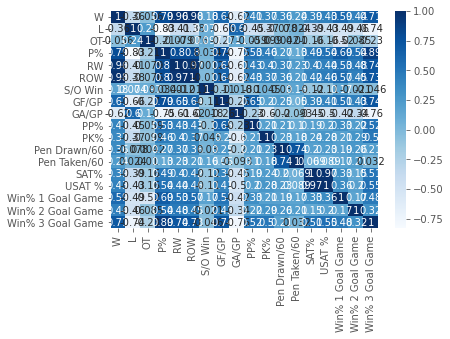

In [21]:
#Create correlation heat map for regular season
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
corr = df_reg.corr()
sns_plot = sns.heatmap(corr, cmap="Blues", annot=True)

fig = sns_plot.get_figure()
fig.savefig("reg_heat.png")

In [23]:
#Reduce postseason dataframe for initial heatmap
df_post = df2[['W','L','OT','P%', 'RW','ROW','GF/GP','GA/GP','PP%','PK%','Pen Drawn/60','Pen Taken/60','SAT%','USAT %','Win% 1 Goal Game','Win% 2 Goal Game', 'Win% 3 Goal Game']]

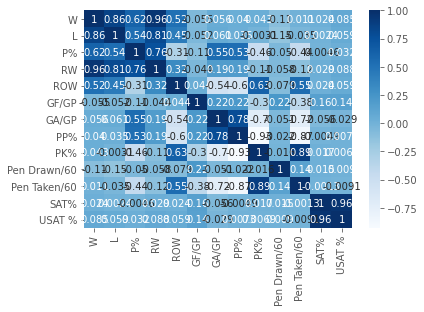

In [24]:
#Create correlation heat map for postseason
corr = df_post.corr()
sns_plot = sns.heatmap(corr, cmap="Blues", annot=True)

fig = sns_plot.get_figure()
fig.savefig("post_heat.png")